In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,  Dataset
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import open3d as o3d
import os
import warnings
from tqdm import tqdm
import pandas as pd
from pathlib import Path

warnings.filterwarnings("ignore")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
ROOT = os.getcwd()
DATA_PATH = os.path.join(ROOT, "..", "data", "raw","ModelNet40")
DATA_PATH = os.path.abspath(DATA_PATH)

In [4]:
for fol in sorted(os.listdir(DATA_PATH)):
    fol_path = os.path.join(DATA_PATH, fol)
    
    if not os.path.isdir(fol_path):
        continue

    train_path = os.path.join(fol_path, "train")
    
    if os.path.exists(train_path):
        files = os.listdir(train_path)
        off_files = [f for f in files if f.endswith('.off')] 
        
        print(f"{fol:<20} | {len(off_files)}")

airplane             | 626
bathtub              | 106
bed                  | 515
bench                | 173
bookshelf            | 572
bottle               | 335
bowl                 | 64
car                  | 197
chair                | 889
cone                 | 167
cup                  | 79
curtain              | 138
desk                 | 200
door                 | 109
dresser              | 200
flower_pot           | 149
glass_box            | 171
guitar               | 155
keyboard             | 145
lamp                 | 124
laptop               | 149
mantel               | 284
monitor              | 465
night_stand          | 200
person               | 88
piano                | 231
plant                | 240
radio                | 104
range_hood           | 115
sink                 | 128
sofa                 | 680
stairs               | 124
stool                | 90
table                | 392
tent                 | 163
toilet               | 344
tv_stand             | 267
vase 

## Trying visaulize

In [5]:
def read_off_with_open3d(file_path, num_points=1024):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
        
    mesh = o3d.io.read_triangle_mesh(file_path)
    pcd = mesh.sample_points_uniformly(number_of_points=num_points)
    o3d.visualization.draw_geometries([mesh], window_name="ModelNet40 Preview")
    print(pcd)
    return mesh

In [6]:
example_path = os.path.join(DATA_PATH, "airplane", "train", "airplane_0004.off")
mesh = read_off_with_open3d(example_path)
print(mesh)

PointCloud with 1024 points.
TriangleMesh with 58194 points and 75957 triangles.


In [ ]:
def is_valid_off_file(file_path, num_points=1024):
    try:
        with open(file_path, 'r') as f:
            header = f.readline().strip()
        if header != 'OFF':
            return False

        mesh = o3d.io.read_triangle_mesh(file_path)
        if len(mesh.triangles) == 0:
            return FalseS

        _ = mesh.sample_points_uniformly(number_of_points=num_points)
        return True
    except:
        return False

In [ ]:
all_files = list(Path(DATA_PATH).rglob('*.off'))

data = []
for file_path in tqdm(all_files, desc="Processing paths"):
    
    if not is_valid_off_file(str(file_path)):
        continue
        
    data.append({
        'path': str(file_path),
        'category': file_path.parts[-3],
        'original_split': file_path.parts[-2]
    })

df = pd.DataFrame(data)

cat_to_idx = {cat: i for i, cat in enumerate(sorted(df['category'].unique()))}
df['label'] = df['category'].map(cat_to_idx)

print(df.head())

Processing paths:  94%|█████████▍| 11546/12311 [17:42<00:23, 32.79it/s] 

In [ ]:

test_df = df[df['original_split'] == 'test'].copy()

train_full_df = df[df['original_split'] == 'train'].copy()

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_full_df, 
    test_size=0.2, 
    stratify=train_full_df['label'], 
    random_state=42
)

train_paths = train_df['path'].tolist()
train_labels = train_df['label'].tolist()
val_paths = val_df['path'].tolist()
val_labels = val_df['label'].tolist()

In [ ]:
class PCD(Dataset):
    def __init__(self, file_paths, labels, num_points=1024):
        self.file_paths= file_paths
        self.labels = labels
        self.num_points = num_points

        self.data_points = []
        self.valid_labels = []
        print(f"Loading {len(file_paths)} files...")
        for i, path in enumerate(tqdm(file_paths)):
            try:
                mesh = o3d.io.read_triangle_mesh(path)
       
                pcd = mesh.sample_points_uniformly(number_of_points=num_points)
                points = np.asarray(pcd.points)
                    

                points = self.pc_normalize(points)
                    
                self.data_points.append(points)
                self.valid_labels.append(labels[i])
            except Exception as e:
                print(f"Skipping bad file: {path}")
                continue
            
    def pc_normalize(self, pc):
 
        centroid = np.mean(pc, axis=0)
        pc = pc - centroid
  
        m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
        pc = pc / m
        return pc
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        points = self.data_points[idx]
        label = self.valid_labels[idx]
        
        return torch.tensor(points, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

    

In [ ]:
batch_size = 32
train_dataset = PCD(train_paths, train_labels)
val_dataset = PCD(val_paths, val_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loading 6071 files into RAM...


100%|██████████| 6071/6071 [11:56<00:00,  8.48it/s]  


Loading 1518 files into RAM...


100%|██████████| 1518/1518 [03:02<00:00,  8.32it/s]


In [ ]:
train_dataset

NameError: name 'train_dataset' is not defined

In [ ]:
class STN3d(nn.Module):
    """ T-Net ตัวแรก: สำหรับหมุน Input Point Cloud (3x3) """
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.from_numpy(np.eye(3).flatten().astype(np.float32)).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

In [ ]:
class STNkd(nn.Module):
    """ T-Net ตัวที่สอง: สำหรับหมุน Feature (k x k) ปกติ k=64 """
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.k = k

    def forward(self, x):
        batchsize = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.from_numpy(np.eye(self.k).flatten().astype(np.float32)).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

In [ ]:
class PointNetFull(nn.Module):
    def __init__(self, num_classes=40):
        super(PointNetFull, self).__init__()
        
        self.stn = STN3d()
        
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fstn = STNkd(k=64)
        
        self.conv3 = torch.nn.Conv1d(64, 64, 1)
        self.conv4 = torch.nn.Conv1d(64, 128, 1)
        self.conv5 = torch.nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)

    def forward(self, x):
        B, D, N = x.size()
        
        trans = self.stn(x)
        x = x.transpose(2, 1) 
        x = torch.bmm(x, trans) #
        x = x.transpose(2, 1)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        trans_feat = self.fstn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans_feat) 
        x = x.transpose(2, 1)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn6(self.fc1(x)))
        x = F.relu(self.bn7(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        
        return x, trans_feat

In [ ]:
num_classes = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetFull(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def feature_transform_regularizer(trans):
    d = trans.size()[1]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

def get_loss(pred, target, trans_feat, mat_diff_loss_scale=0.001):
    loss_cls = F.cross_entropy(pred, target)
    
    loss_reg = feature_transform_regularizer(trans_feat)
    
    total_loss = loss_cls + (mat_diff_loss_scale * loss_reg)
    return total_loss

In [ ]:
for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct = 0

    for point_clouds, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        point_clouds, labels = point_clouds.to(device), labels.to(device)

        point_clouds = point_clouds.transpose(1, 2) 

        optimizer.zero_grad()
        
        outputs, trans_feat = model(point_clouds) 
        
        loss = get_loss(outputs, labels, trans_feat)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    acc = correct / len(train_dataset) 
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {acc*100:.2f}%")

Epoch 1: 100%|██████████| 190/190 [00:21<00:00,  8.95it/s]


Epoch 1 - Loss: 2.2391, Train Accuracy: 42.58%


Epoch 2: 100%|██████████| 190/190 [00:20<00:00,  9.25it/s]


Epoch 2 - Loss: 1.5580, Train Accuracy: 55.76%


Epoch 3: 100%|██████████| 190/190 [00:20<00:00,  9.28it/s]


Epoch 3 - Loss: 1.2975, Train Accuracy: 63.32%


Epoch 4: 100%|██████████| 190/190 [00:20<00:00,  9.44it/s]


Epoch 4 - Loss: 1.0544, Train Accuracy: 69.53%


Epoch 5: 100%|██████████| 190/190 [00:19<00:00,  9.52it/s]


Epoch 5 - Loss: 0.9537, Train Accuracy: 72.41%


Epoch 6: 100%|██████████| 190/190 [00:19<00:00,  9.50it/s]


Epoch 6 - Loss: 0.8903, Train Accuracy: 73.45%


Epoch 7: 100%|██████████| 190/190 [00:19<00:00,  9.53it/s]


Epoch 7 - Loss: 0.8260, Train Accuracy: 75.46%


Epoch 8: 100%|██████████| 190/190 [00:20<00:00,  9.39it/s]


Epoch 8 - Loss: 0.7200, Train Accuracy: 78.54%


Epoch 9: 100%|██████████| 190/190 [00:20<00:00,  9.20it/s]


Epoch 9 - Loss: 0.6953, Train Accuracy: 79.16%


Epoch 10: 100%|██████████| 190/190 [00:20<00:00,  9.12it/s]


Epoch 10 - Loss: 0.6737, Train Accuracy: 79.21%


Epoch 11: 100%|██████████| 190/190 [00:20<00:00,  9.22it/s]


Epoch 11 - Loss: 0.6103, Train Accuracy: 81.24%


Epoch 12: 100%|██████████| 190/190 [00:20<00:00,  9.22it/s]


Epoch 12 - Loss: 0.5860, Train Accuracy: 81.91%


Epoch 13: 100%|██████████| 190/190 [00:20<00:00,  9.49it/s]


Epoch 13 - Loss: 0.5576, Train Accuracy: 82.98%


Epoch 14: 100%|██████████| 190/190 [00:19<00:00,  9.59it/s]


Epoch 14 - Loss: 0.5179, Train Accuracy: 84.09%


Epoch 15: 100%|██████████| 190/190 [00:19<00:00,  9.62it/s]


Epoch 15 - Loss: 0.5306, Train Accuracy: 83.63%


Epoch 16: 100%|██████████| 190/190 [00:19<00:00,  9.63it/s]


Epoch 16 - Loss: 0.5270, Train Accuracy: 83.51%


Epoch 17: 100%|██████████| 190/190 [00:19<00:00,  9.54it/s]


Epoch 17 - Loss: 0.4803, Train Accuracy: 85.08%


Epoch 18: 100%|██████████| 190/190 [00:20<00:00,  9.42it/s]


Epoch 18 - Loss: 0.4629, Train Accuracy: 85.22%


Epoch 19: 100%|██████████| 190/190 [00:20<00:00,  9.45it/s]


Epoch 19 - Loss: 0.4368, Train Accuracy: 86.13%


Epoch 20: 100%|██████████| 190/190 [00:20<00:00,  9.44it/s]

Epoch 20 - Loss: 0.4549, Train Accuracy: 85.22%


In [ ]:
model.eval()
correct = 0
with torch.no_grad():
    for point_clouds, labels in val_loader:
        point_clouds, labels = point_clouds.to(device), labels.to(device)
        outputs = model(point_clouds)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
val_acc = correct / len(val_dataset)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

print("Robust 3D Object Classification Pipeline Completed Successfully.")

Validation Accuracy: 83.86%
Robust 3D Object Classification Pipeline Completed Successfully.


In [ ]:
categories = sorted(os.listdir(DATA_PATH))
label_encoder = LabelEncoder()
label_encoder.fit(categories)

LabelEncoder()

In [ ]:
idx_to_class = {i: label for i, label in enumerate(label_encoder.classes_)}

model.eval()
with torch.no_grad():
    for i in range(5):
        points, true_label = val_dataset[i]
        input_points = points.unsqueeze(0).to(device)
        outputs = model(input_points)
        pred_label_idx = outputs.argmax(dim=1).item()
        pred_label_name = idx_to_class[pred_label_idx]
        true_label_name = idx_to_class[true_label.item()]
        
        print(f"True: {true_label_name}, Predicted: {pred_label_name}")

True: bathtub, Predicted: bathtub
True: sofa, Predicted: bookshelf
True: airplane, Predicted: airplane
True: car, Predicted: car
True: mantel, Predicted: mantel


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def visualize_point_cloud_matplotlib(points, predicted_label):
    """
    Visualize a 3D point cloud using Matplotlib with predicted class in title.
    """
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='b', alpha=0.8)
    ax.set_title(f'Predicted Class: {predicted_label}', fontsize=14)

    ax.set_axis_off()
    ax.view_init(elev=20, azim=30)
    
    plt.show()

True: bathtub, Predicted: bathtub


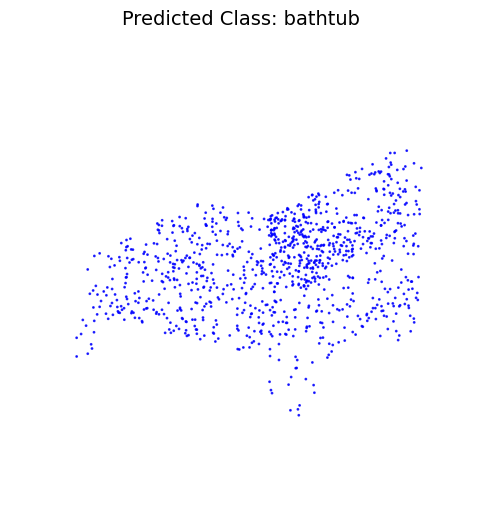

True: sofa, Predicted: bookshelf


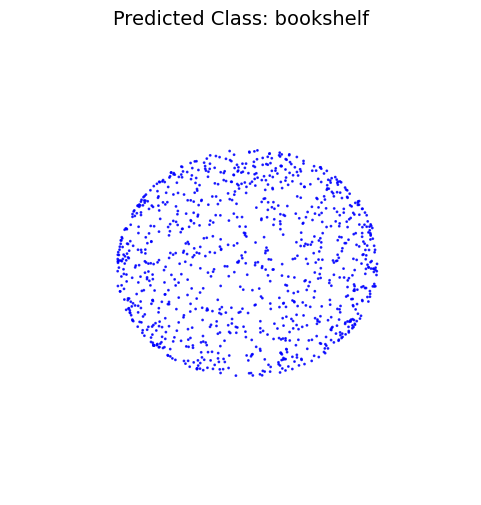

True: airplane, Predicted: airplane


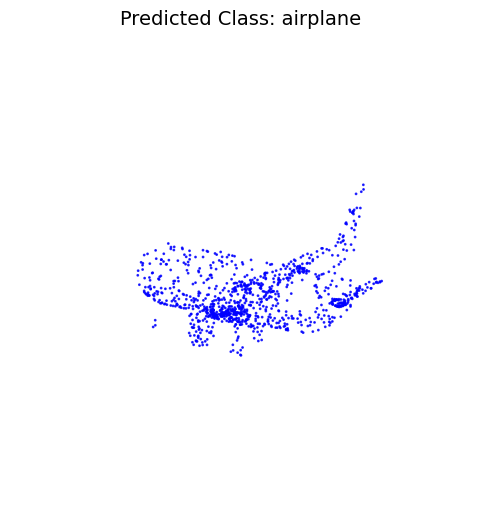

True: car, Predicted: car


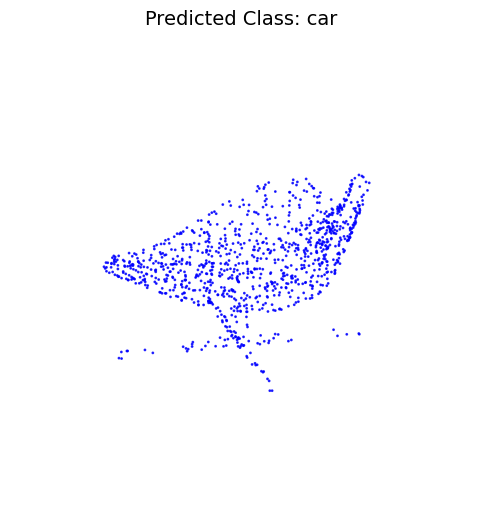

True: mantel, Predicted: mantel


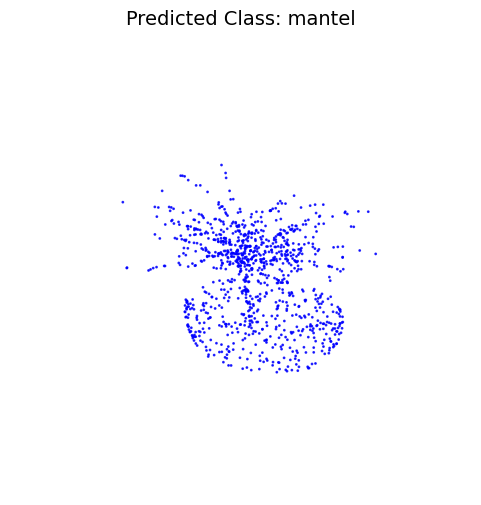

In [ ]:
idx_to_class = {i: label for i, label in enumerate(label_encoder.classes_)}

model.eval()
with torch.no_grad():
    for i in range(5):
        points, true_label = val_dataset[i]
        input_points = points.unsqueeze(0).to(device)
        outputs = model(input_points)
        pred_label_idx = outputs.argmax(dim=1).item()
        pred_label_name = idx_to_class[pred_label_idx]
        true_label_name = idx_to_class[true_label.item()]
        
        print(f"True: {true_label_name}, Predicted: {pred_label_name}")
        
        points_np = np.array(points.cpu().tolist())
        visualize_point_cloud_matplotlib(points_np, pred_label_name)